# Event Segmentation Analysis

The following notebook contains the formal analysis procedure for the hidden markov modeling of continuous fMRI data.

# Imports

A good portion of this analysis is built on `decker_honors_module`, an installable "package" created specifically to streamline Will Decker's honors thesis project. Usage and notes on this code are located in the GitHub repo [here](https://github.com/w-decker/decker_honors_module). Other important dependencies include [Brainiak](brainiak.org) and [Nilearn](https://nilearn.github.io/stable/index.html). Some `conda` environments have been created to certain portions of the code. `.yml` files will be included and named according to their dedicated use. 

# Importing data

`decker.utils.io.io` contains a class, `BIDSio` created to handle the project's data in BIDS format. There is also a conda environment dedicated to just this procedure.

You only need to **run once!**

In [ ]:
!wget # add .yml
!conda create -f bidsio.yml
!conda activate bidio

In [4]:
# import BIDSio
from decker.utils.io.io import BIDSio

Get the data to the environment by showing `BIDSio` where the BIDS root is.

In [5]:
bids_root = "/data/jdecke5/projects/honors-thesis/data/bids"
bids = BIDSio(bids_path=bids_root)

# bind bids_root to BIDSio
bids.init()

BIDSio(bids_path='/data/jdecke5/projects/honors-thesis/data/bids')

Display some information about the BIDS dataset.

In [6]:
bids.info()

Subjects: 
	 ['SL001', 'SL002', 'SL003', 'SL004', 'SL005', 'SL006', 'SL007', 'SL008', 'SL009', 'SL010', 'SL011', 'SL012', 'SL013', 'SL014', 'SL015', 'SL016', 'SL017', 'SL018', 'SL019']

Total subjects: 
	 19

Tasks: 
	 ['rest', 'statlearning']

Total tasks: 
	 2



Get list of functional data.

In [7]:
data = bids.get_func(task='statlearning', suffix="bold")
data

['/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL001/func/sub-SL001_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL002/func/sub-SL002_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL003/func/sub-SL003_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL004/func/sub-SL004_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL005/func/sub-SL005_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL006/func/sub-SL006_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projec

We can ensure that we have to correct number of files by comparing output from `BIDSio.info()` and `BIDSio.ge_func()`.

# Importing participant database

`decker.utils.io.io` contains a function, `parse_pdb()`, which reads a file (either .xlsx or .csv) and transposes it based on a factor. So in this case, it transposes our data from wide to long by the conditions each participant belongs to.

In [8]:
from decker.utils.io.io import parse_pdb

In [9]:
db = "/data/jdecke5/projects/honors-thesis/data/participant_database.xlsx"
pps = parse_pdb(path=db, subid_col="Subject ID", cond_col="COND")

Let's see what this looks like.

In [10]:
pps

{'S': ['SL001',
  'SL003',
  'SL004',
  'SL007',
  'SL009',
  'SL011',
  'SL013',
  'SL015',
  'SL017',
  'SL019'],
 'R': ['SL002',
  'SL005',
  'SL006',
  'SL008',
  'SL010',
  'SL012',
  'SL014',
  'SL016',
  'SL018']}

You can see now that the subject IDs of each participant have been grouped by which condition they are in.

Now let's mask the data.

In [11]:
# imports
from decker.analysis.utils.utils import nilearn_mask_single_data, nilearn_mask_group_by_condition
from decker.utils.io.io import get_subid
import numpy as np

Demonstrating on one subject

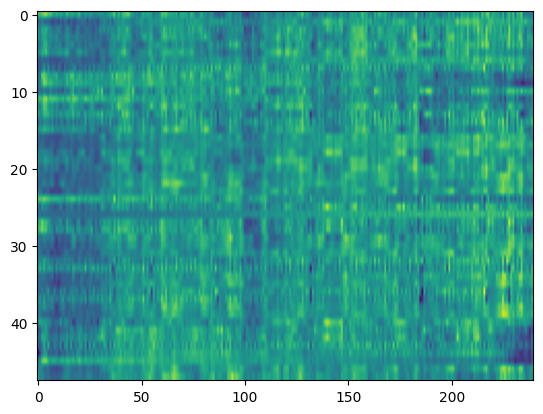

In [12]:
roidat, labels, report = nilearn_mask_single_data(atlas="cort-maxprob-thr25-1mm", file=data[0], report=True, plot=True)
report

Now let's do this for each subject